In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class ECGPreprocessor:
    """ECG signal preprocessing optimized for 1-minute data"""

    def __init__(self, fs=500):
        self.fs = fs  # Sampling frequency

    def apply_bandpass_filter(self, ecg_signal, lowcut=0.5, highcut=45):
        """Apply bandpass filter optimized for 1-minute data"""
        nyquist = self.fs / 2
        low = lowcut / nyquist
        high = highcut / nyquist

        # Design Butterworth bandpass filter - order 3 for better filtering
        b, a = signal.butter(3, [low, high], btype='band')
        filtered_signal = signal.filtfilt(b, a, ecg_signal)

        # Notch filter for 50Hz/60Hz power line interference
        notch_freq = 50.0  # Change to 60.0 for US data
        quality_factor = 20.0  # Increased Q factor for better notch filtering
        b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, self.fs)
        filtered_signal = signal.filtfilt(b_notch, a_notch, filtered_signal)

        return filtered_signal

    def detect_r_peaks(self, ecg_signal):
        """R-peak detection optimized for 1-minute data"""
        # Normalize signal
        normalized_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)

        # Apply smoothing with optimized sigma
        from scipy.ndimage import gaussian_filter1d
        smoothed = gaussian_filter1d(normalized_signal, sigma=2.0)

        # Find peaks with parameters optimized for 1-minute data
        # For 1-minute: expect 50-120 BPM, so 0.5-1.2 seconds between peaks
        min_distance = int(0.5 * self.fs)  # Minimum 0.5s between R-peaks (120 BPM max)
        height_threshold = np.percentile(smoothed, 65)  # Adjusted threshold

        # Calculate prominence threshold based on signal characteristics
        prominence_threshold = 0.3 * np.std(smoothed)

        peaks, properties = find_peaks(smoothed,
                                     distance=min_distance,
                                     height=height_threshold,
                                     prominence=prominence_threshold)

        # Filter out peaks that are too close to start/end for proper segmentation
        valid_peaks = []
        for peak in peaks:
            if peak >= 150 and peak <= (len(ecg_signal) - 250):  # Ensure segmentation space
                valid_peaks.append(peak)

        return np.array(valid_peaks)

    def segment_heartbeats(self, ecg_signal, r_peaks, before_samples=150, after_samples=250):
        """
        Extract heartbeat segments optimized for 1-minute data
        before_samples: 0.3s * 500Hz = 150 samples
        after_samples: 0.5s * 500Hz = 250 samples
        Total: 400 samples (0.8s per heartbeat) - covers full cardiac cycle
        """
        segments = []

        for r_peak in r_peaks:
            start_idx = r_peak - before_samples
            end_idx = r_peak + after_samples

            if start_idx >= 0 and end_idx < len(ecg_signal):
                segment = ecg_signal[start_idx:end_idx]
                if len(segment) == (before_samples + after_samples):
                    segments.append(segment)

        return np.array(segments)

    def normalize_amplitude(self, segments, target_amplitude=1.0):
        """Normalize segment amplitudes for 1-minute data"""
        normalized_segments = []

        for segment in segments:
            # Remove baseline drift
            segment_detrended = signal.detrend(segment)

            # Calculate robust amplitude (using percentiles to avoid outliers)
            amplitude_range = np.percentile(segment_detrended, 95) - np.percentile(segment_detrended, 5)

            if amplitude_range > 0:
                normalized_segment = segment_detrended * (target_amplitude / amplitude_range)
                normalized_segments.append(normalized_segment)

        return np.array(normalized_segments)

    def generate_template(self, segments, max_segments=8):
        """Generate template from ECG segments for 1-minute data"""
        if len(segments) < 2:
            return np.mean(segments, axis=0)

        # For 1-minute data, use more segments for better template
        num_segments = min(max_segments, len(segments))

        # Compute element-wise median for robustness
        median_segment = np.median(segments, axis=0)

        # Find segments closest to median
        distances = [np.linalg.norm(segment - median_segment) for segment in segments]
        closest_indices = np.argsort(distances)[:num_segments]

        # Average the closest segments
        template = np.mean(segments[closest_indices], axis=0)

        return template

    def generate_summary_segments(self, segments, block_size=5):
        """Generate summary segments for 1-minute data"""
        summary_segments = []

        # For 1-minute data, use larger block size
        for i in range(0, len(segments) - block_size + 1, block_size):
            block = segments[i:i + block_size]
            if len(block) == block_size:
                summary_segment = self.generate_template(block)
                summary_segments.append(summary_segment)

        return np.array(summary_segments)

class ECGAutoencoder:
    """Autoencoder optimized for 1-minute ECG data"""

    def __init__(self, input_length=400):  # Full cardiac cycle length
        self.input_length = input_length
        self.model = None
        self.encoder = None
        self.history = None

    def build_model(self):
        """Build autoencoder optimized for 1-minute data"""
        # Input layer
        input_layer = layers.Input(shape=(self.input_length, 1))

        # Encoder - deeper network for better feature extraction
        x = layers.Conv1D(64, 7, activation='relu', padding='same')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.15)(x)

        x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.15)(x)

        x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.15)(x)

        x = layers.Conv1D(512, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.2)(x)

        # Feature extraction layer (increased to 8 channels for richer features)
        encoded = layers.Conv1D(8, 3, activation='relu', padding='same')(x)

        # Decoder - symmetric to encoder
        x = layers.Conv1D(512, 3, activation='relu', padding='same')(encoded)
        x = layers.UpSampling1D(2)(x)
        x = layers.Dropout(0.15)(x)

        x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)
        x = layers.Dropout(0.15)(x)

        x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)
        x = layers.Dropout(0.15)(x)

        x = layers.Conv1D(64, 7, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)

        # Output layer
        decoded = layers.Conv1D(1, 7, activation='linear', padding='same')(x)

        # Create models
        self.model = Model(input_layer, decoded)
        self.encoder = Model(input_layer, encoded)

        # Compile with optimized learning rate
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999),
            loss='mse',
            metrics=['mae']
        )

        return self.model

    def train(self, X_train, epochs=40, batch_size=32, validation_split=0.2):
        """Train autoencoder for 1-minute data"""
        if self.model is None:
            self.build_model()

        # Callbacks optimized for 1-minute data
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.0001
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=6,
            min_lr=1e-7,
            verbose=1
        )

        # Prepare data
        Xr = X_train.reshape(-1, self.input_length, 1)

        # Fit model
        self.history = self.model.fit(
            Xr, Xr,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        return self.history

    def extract_features(self, segments):
        """Extract features using trained encoder"""
        if self.encoder is None:
            raise ValueError("Model must be trained first")

        segments_reshaped = segments.reshape(-1, self.input_length, 1)
        features = self.encoder.predict(segments_reshaped, verbose=0)

        # Flatten features
        features_flattened = features.reshape(features.shape[0], -1)

        return features_flattened

class SiameseCNN:
    """Siamese CNN optimized for 1-minute ECG data"""

    def __init__(self, feature_dim=200, num_classes=47):  # Increased feature dimension
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.model = None
        self.identification_model = None
        self.history = None

    def create_base_network(self):
        """Create base network for 1-minute data"""
        input_layer = layers.Input(shape=(self.feature_dim,))

        # Deeper network for better discrimination
        x = layers.Dense(1024, activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        output = layers.Dense(64, activation='relu')(x)

        return Model(input_layer, output)

    def build_identification_model(self):
        """Build identification model for 1-minute data"""
        base_network = self.create_base_network()

        input_layer = layers.Input(shape=(self.feature_dim,))
        features = base_network(input_layer)

        # Classification layer with residual connection
        x = layers.Dense(128, activation='relu')(features)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        output = layers.Dense(self.num_classes, activation='softmax')(x)

        self.identification_model = Model(input_layer, output)
        self.identification_model.compile(
            optimizer=optimizers.Adam(learning_rate=0.0015, beta_1=0.9, beta_2=0.999),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.identification_model

class ECGBiometricSystem:
    """ECG Biometric System optimized for 1-minute data"""

    def __init__(self):
        self.preprocessor = ECGPreprocessor()
        self.autoencoder = ECGAutoencoder()
        self.siamese_cnn = SiameseCNN()
        self.templates = {}
        self.person_ids = []
        self.label_to_person_id = {}
        self.person_id_to_label = {}
        self.evaluation_results = {}

    def load_training_data(self, file_path):
        """Load training data optimized for 1-minute data"""
        try:
            # Load data
            df = pd.read_csv(file_path)
            print(f"Loaded training data: {df.shape}")
            print(f"Columns: {df.columns.tolist()}")

            # Extract unique person IDs
            unique_person_ids = df['Person_ID'].unique()
            self.person_ids = list(unique_person_ids)

            # Create label mappings
            for idx, person_id in enumerate(unique_person_ids):
                self.label_to_person_id[idx] = person_id
                self.person_id_to_label[person_id] = idx

            # Process each person's data
            all_segments = []
            all_labels = []

            for idx, row in df.iterrows():
                person_id = row['Person_ID']

                # Extract MLII signal
                mlii_signal = self._parse_signal_array(row['MLII_segment'])

                if len(mlii_signal) > 0:
                    # Preprocess signal
                    filtered_signal = self.preprocessor.apply_bandpass_filter(mlii_signal)
                    r_peaks = self.preprocessor.detect_r_peaks(filtered_signal)
                    segments = self.preprocessor.segment_heartbeats(filtered_signal, r_peaks)

                    # For 1-minute data, expect 50-120 heartbeats based on HR range
                    if len(segments) > 120:
                        segments = segments[:120]  # Limit to maximum expected

                    if len(segments) >= 8:  # Minimum segments required for reliable identification
                        normalized_segments = self.preprocessor.normalize_amplitude(segments)

                        # Use more segments for training (up to 50 for better learning)
                        if len(normalized_segments) > 50:
                            normalized_segments = normalized_segments[:50]

                        # Generate template
                        template = self.preprocessor.generate_template(normalized_segments)
                        self.templates[person_id] = template

                        # Add segments to training data
                        person_label = self.person_id_to_label[person_id]
                        all_segments.extend(normalized_segments)
                        all_labels.extend([person_label] * len(normalized_segments))

            print(f"Total segments extracted: {len(all_segments)}")
            print(f"Segments per person (avg): {len(all_segments) / len(self.person_ids):.1f}")

            return np.array(all_segments), np.array(all_labels)

        except Exception as e:
            print(f"Error loading training data: {e}")
            return None, None

    def load_test_data(self, path):
        """Load test data for 1-minute ECG"""
        df = pd.read_csv(path)
        clean_cols = {c: c.strip("'\" ") for c in df.columns}
        df = df.rename(columns=clean_cols)

        mlii_cols = [c for c in df.columns if 'mlii' in c.lower()]
        if not mlii_cols:
            raise KeyError(f"No MLII column found. Available: {df.columns.tolist()}")

        col = mlii_cols[0]
        first = df[col].iloc[0]

        if isinstance(first, str) and first.strip().startswith('['):
            raw = self._parse_signal_array(first)
        else:
            raw = df[col].to_numpy(dtype=float)

        if raw.size == 0:
            raise ValueError("Test ECG signal is empty.")

        # Preprocess
        filtered = self.preprocessor.apply_bandpass_filter(raw)
        peaks = self.preprocessor.detect_r_peaks(filtered)
        segments = self.preprocessor.segment_heartbeats(filtered, peaks)

        if len(segments) == 0:
            raise ValueError("No valid heartbeat segments extracted.")

        normalized_segments = self.preprocessor.normalize_amplitude(segments)
        return normalized_segments

    def _parse_signal_array(self, signal_str):
        """Parse signal array from string representation"""
        try:
            if isinstance(signal_str, str):
                signal_str = signal_str.strip('[]')
                signal_values = [float(x.strip()) for x in signal_str.split(',')]
                return np.array(signal_values)
            else:
                return np.array(signal_str)
        except:
            return np.array([])

    def train_system(self, X_train, y_train, test_size=0.2):
        """Train the system for 1-minute data"""
        print("Splitting data for validation...")
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=test_size, random_state=42, stratify=y_train
        )

        print("Training Autoencoder for 1-minute data...")
        history_ae = self.autoencoder.train(X_train_split, batch_size=32, epochs=40)

        print("Extracting features...")
        train_features = self.autoencoder.extract_features(X_train_split)
        val_features = self.autoencoder.extract_features(X_val_split)

        # Update dimensions
        self.siamese_cnn.feature_dim = train_features.shape[1]
        self.siamese_cnn.num_classes = len(np.unique(y_train))

        print("Training Siamese CNN for 1-minute data...")
        self.siamese_cnn.build_identification_model()

        history_siamese = self.siamese_cnn.identification_model.fit(
            train_features, y_train_split,
            epochs=50,  # Increased epochs for better convergence
            batch_size=32,
            validation_data=(val_features, y_val_split),
            callbacks=[
                EarlyStopping(patience=15, restore_best_weights=True, min_delta=0.0001),
                ReduceLROnPlateau(patience=7, factor=0.5, min_lr=1e-7, verbose=1)
            ],
            verbose=1
        )

        # Store validation data
        self.X_val = X_val_split
        self.y_val = y_val_split
        self.val_features = val_features
        self.siamese_cnn.history = history_siamese

        return history_ae, history_siamese

    def evaluate_validation_set(self):
        """Evaluate model on validation set"""
        print("Evaluating on validation set...")

        val_predictions = self.siamese_cnn.identification_model.predict(self.val_features)
        y_val_pred = np.argmax(val_predictions, axis=1)

        accuracy = accuracy_score(self.y_val, y_val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_val, y_val_pred, average='weighted')

        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation Precision: {precision:.4f}")
        print(f"Validation Recall: {recall:.4f}")
        print(f"Validation F1-Score: {f1:.4f}")

        self.evaluation_results['validation'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_true': self.y_val,
            'y_pred': y_val_pred,
            'y_pred_proba': val_predictions
        }

        return accuracy, precision, recall, f1

    def identify_person(self, test_segments):
        """Enhanced person identification for 1-minute data"""
        test_features = self.autoencoder.extract_features(test_segments)

        # Multiple approaches for robust identification

        # 1. Summary segments approach (averaging blocks of heartbeats)
        summary_segments = self.preprocessor.generate_summary_segments(test_segments, block_size=6)
        if len(summary_segments) > 0:
            summary_features = self.autoencoder.extract_features(summary_segments)
            summary_predictions = self.siamese_cnn.identification_model.predict(summary_features, verbose=0)
            avg_summary_predictions = np.mean(summary_predictions, axis=0)
        else:
            avg_summary_predictions = np.zeros(self.siamese_cnn.num_classes)

        # 2. All segments approach
        all_predictions = self.siamese_cnn.identification_model.predict(test_features, verbose=0)
        avg_all_predictions = np.mean(all_predictions, axis=0)

        # 3. Top confidence segments approach
        max_confidences = np.max(all_predictions, axis=1)
        top_k = min(10, len(test_segments))  # Top 10 segments
        top_segments_idx = np.argsort(max_confidences)[-top_k:]
        top_features = test_features[top_segments_idx]
        top_predictions = self.siamese_cnn.identification_model.predict(top_features, verbose=0)
        avg_top_predictions = np.mean(top_predictions, axis=0)

        # 4. Median approach (robust to outliers)
        median_predictions = np.median(all_predictions, axis=0)

        # Combine predictions with optimized weights for 1-minute data
        final_predictions = (0.25 * avg_summary_predictions +
                           0.30 * avg_all_predictions +
                           0.25 * avg_top_predictions +
                           0.20 * median_predictions)

        predicted_label = np.argmax(final_predictions)
        confidence = final_predictions[predicted_label]
        predicted_person_id = self.label_to_person_id[predicted_label]

        return predicted_person_id, confidence, final_predictions, predicted_label

    def evaluate_system(self, test_segments, true_person_id=None):
        """Evaluate the biometric system"""
        predicted_id, confidence, all_predictions, predicted_label = self.identify_person(test_segments)

        print(f"Predicted Person ID: {predicted_id}")
        print(f"Confidence: {confidence:.4f}")

        is_correct = False
        if true_person_id is not None:
            print(f"True Person ID: {true_person_id}")
            is_correct = (predicted_id == true_person_id)
            print(f"Correct: {'Yes' if is_correct else 'No'}")

        # Show top 5 predictions
        if all_predictions is not None:
            top_5_indices = np.argsort(all_predictions)[-5:][::-1]
            print("\nTop 5 predictions:")
            for i, idx in enumerate(top_5_indices):
                person_id = self.label_to_person_id[idx]
                prob = all_predictions[idx]
                print(f"{i+1}. Person {person_id}: {prob:.4f}")

        return predicted_id, confidence, is_correct

    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Autoencoder loss
        if self.autoencoder.history:
            axes[0, 0].plot(self.autoencoder.history.history['loss'], label='Training Loss', color='blue')
            axes[0, 0].plot(self.autoencoder.history.history['val_loss'], label='Validation Loss', color='red')
            axes[0, 0].set_title('Autoencoder Loss (1-minute data)')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

        # Siamese CNN loss
        if self.siamese_cnn.history:
            axes[0, 1].plot(self.siamese_cnn.history.history['loss'], label='Training Loss', color='blue')
            axes[0, 1].plot(self.siamese_cnn.history.history['val_loss'], label='Validation Loss', color='red')
            axes[0, 1].set_title('Siamese CNN Loss (1-minute data)')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # Siamese CNN accuracy
        if self.siamese_cnn.history:
            axes[1, 0].plot(self.siamese_cnn.history.history['accuracy'], label='Training Accuracy', color='blue')
            axes[1, 0].plot(self.siamese_cnn.history.history['val_accuracy'], label='Validation Accuracy', color='red')
            axes[1, 0].set_title('Siamese CNN Accuracy (1-minute data)')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

        # Sample ECG segments
        if hasattr(self, 'X_val') and len(self.X_val) > 0:
            axes[1, 1].plot(self.X_val[0], color='green', linewidth=2)
            axes[1, 1].set_title('Sample ECG Segment (1-minute data)')
            axes[1, 1].set_xlabel('Sample Point')
            axes[1, 1].set_ylabel('Amplitude')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        if 'validation' not in self.evaluation_results:
            print("No validation results available. Run evaluate_validation_set() first.")
            return

        y_true = self.evaluation_results['validation']['y_true']
        y_pred = self.evaluation_results['validation']['y_pred']

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 10))

        if len(self.person_ids) <= 20:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=[f'P{pid}' for pid in self.person_ids],
                       yticklabels=[f'P{pid}' for pid in self.person_ids])
            plt.title('Confusion Matrix - Person Identification (1-minute data)')
            plt.xlabel('Predicted Person ID')
            plt.ylabel('True Person ID')
        else:
            sns.heatmap(cm, cmap='Blues')
            plt.title(f'Confusion Matrix - {len(self.person_ids)} Persons (1-minute data)')
            plt.xlabel('Predicted Person ID')
            plt.ylabel('True Person ID')

        plt.tight_layout()
        plt.show()

        # Print classification report
        print("\nClassification Report for 1-minute data:")
        target_names = [f'Person_{pid}' for pid in self.person_ids]
        print(classification_report(y_true, y_pred, target_names=target_names))

    def generate_evaluation_report(self):
        """Generate evaluation report"""
        print("="*60)
        print("ECG BIOMETRIC SYSTEM EVALUATION REPORT (1-MINUTE DATA)")
        print("="*60)

        if 'validation' in self.evaluation_results:
            results = self.evaluation_results['validation']
            print(f"Number of classes: {len(self.person_ids)}")
            print(f"Validation samples: {len(results['y_true'])}")
            print(f"Overall Accuracy: {results['accuracy']:.4f}")
            print(f"Weighted Precision: {results['precision']:.4f}")
            print(f"Weighted Recall: {results['recall']:.4f}")
            print(f"Weighted F1-Score: {results['f1_score']:.4f}")

        print("\nModel Architecture Summary (1-minute data):")
        print(f"- Input ECG segment length: {self.autoencoder.input_length}")
        print(f"- Feature dimension: {self.siamese_cnn.feature_dim}")
        print(f"- Number of persons: {len(self.person_ids)}")
        print(f"- Data duration: 1 minute per sample")
        print(f"- Expected heartbeats per minute: 50-120")
        print(f"- Minimum segments required: 8")

ECG BIOMETRIC SYSTEM FOR 1-MINUTE DATA

1. Loading training data...
Loaded training data: (47, 3)
Columns: ['Person_ID', 'MLII_segment', 'V1_segment']
Total segments extracted: 2330
Segments per person (avg): 49.6
Training data loaded successfully!
Total segments: 2330
Segment length: 400
Number of persons: 47

2. Training the biometric system...
Splitting data for validation...
Training Autoencoder for 1-minute data...
Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - loss: 0.1947 - mae: 0.2328 - val_loss: 0.1999 - val_mae: 0.2304 - learning_rate: 8.0000e-04
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0249 - mae: 0.0816 - val_loss: 0.1857 - val_mae: 0.2222 - learning_rate: 8.0000e-04
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0203 - mae: 0.0696 - val_loss: 0.1828 - val_mae: 0.2190 - learning_rate: 8.0000e-04
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0147 - mae: 0.0620 - val_loss: 0.1691 - val_mae: 0.2091 - learning_rate: 8.000

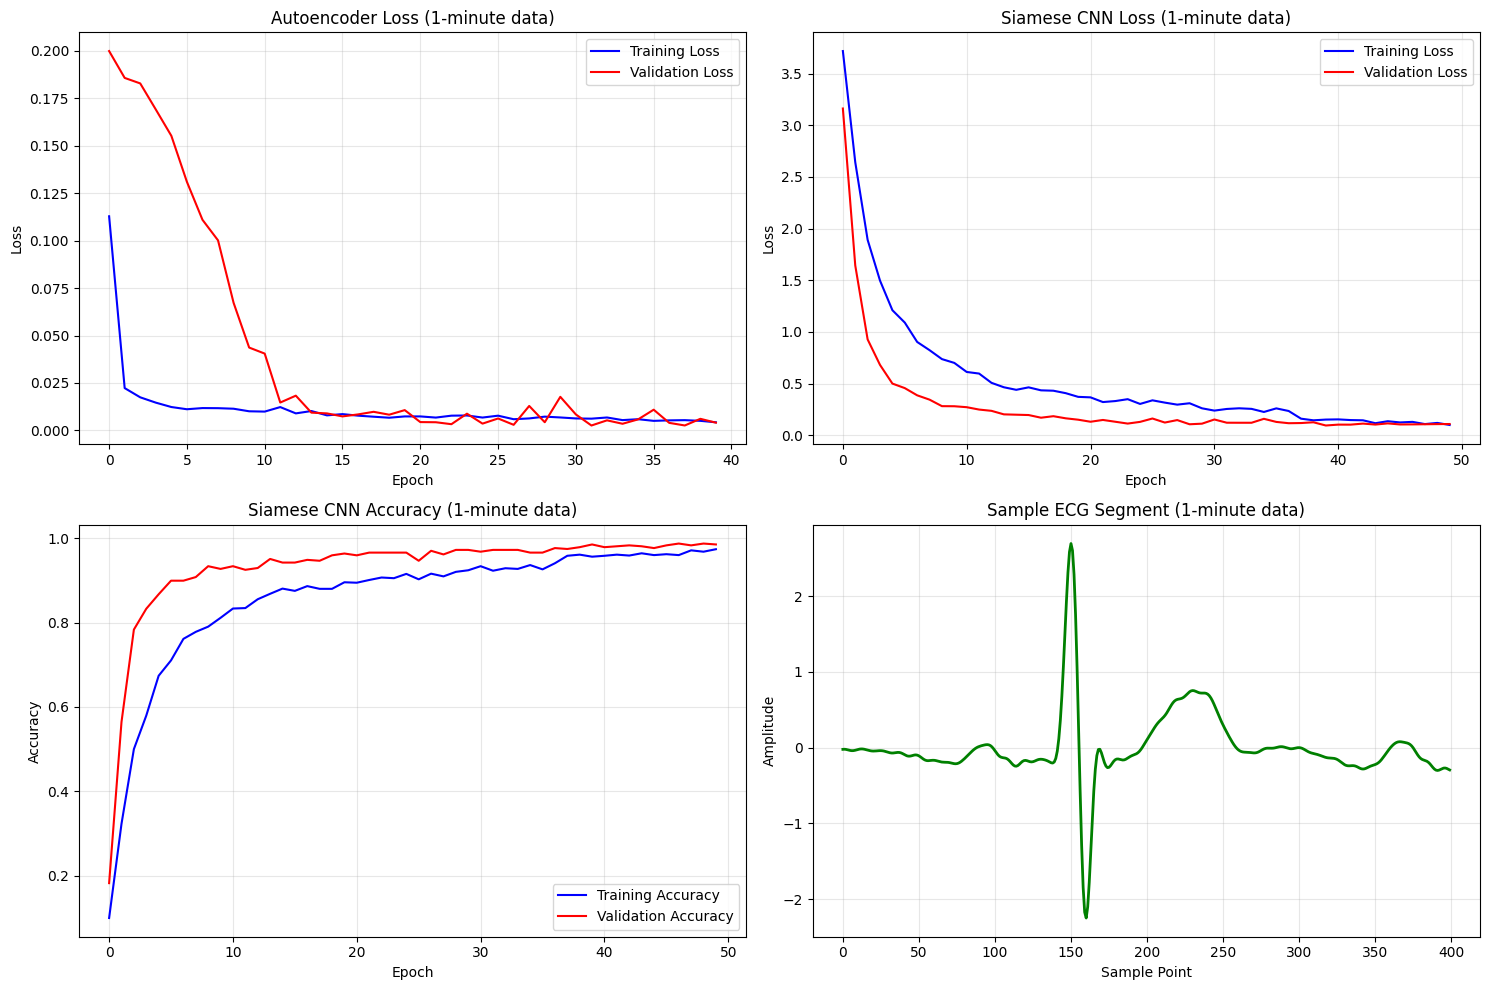

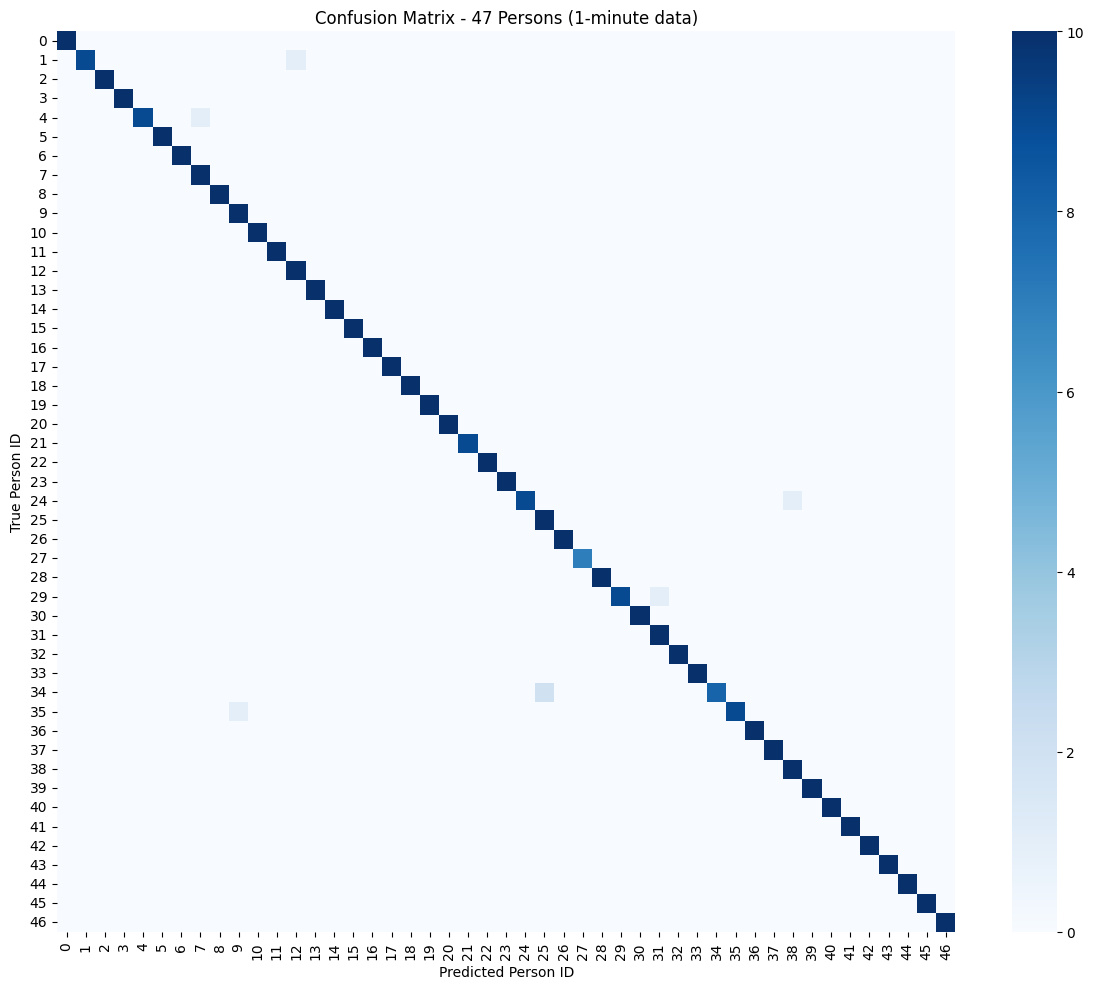


Classification Report for 1-minute data:
              precision    recall  f1-score   support

  Person_100       1.00      1.00      1.00        10
  Person_101       1.00      0.90      0.95        10
  Person_102       1.00      1.00      1.00        10
  Person_103       1.00      1.00      1.00        10
  Person_104       1.00      0.90      0.95        10
  Person_105       1.00      1.00      1.00        10
  Person_106       1.00      1.00      1.00        10
  Person_107       0.91      1.00      0.95        10
  Person_108       1.00      1.00      1.00        10
  Person_109       0.91      1.00      0.95        10
  Person_111       1.00      1.00      1.00        10
  Person_112       1.00      1.00      1.00        10
  Person_113       0.91      1.00      0.95        10
  Person_114       1.00      1.00      1.00        10
  Person_115       1.00      1.00      1.00        10
  Person_116       1.00      1.00      1.00        10
  Person_117       1.00      1.00      

In [6]:
def main():
    """Main function for 1-minute ECG data processing"""

    # Initialize system
    ecg_system = ECGBiometricSystem()

    # File paths - UPDATE THESE TO YOUR 1-MINUTE DATA FILES
    TRAINING_DATA_PATH = '/content/1min.csv'  # Replace with your 1-minute training data
    TEST_DATA_PATH = '/content/105_1min.csv'          # Replace with your 1-minute test data

    print("="*60)
    print("ECG BIOMETRIC SYSTEM FOR 1-MINUTE DATA")
    print("="*60)

    try:
        # Load and prepare training data
        print("\n1. Loading training data...")
        X_train, y_train = ecg_system.load_training_data(TRAINING_DATA_PATH)

        if X_train is None or len(X_train) == 0:
            print("Error: Could not load training data")
            return

        print(f"Training data loaded successfully!")
        print(f"Total segments: {len(X_train)}")
        print(f"Segment length: {X_train.shape[1]}")
        print(f"Number of persons: {len(ecg_system.person_ids)}")

        # Train the system
        print("\n2. Training the biometric system...")
        history_ae, history_siamese = ecg_system.train_system(X_train, y_train)

        # Evaluate on validation set
        print("\n3. Evaluating on validation set...")
        val_accuracy, val_precision, val_recall, val_f1 = ecg_system.evaluate_validation_set()

        # Load test data
        print("\n4. Loading test data...")
        test_segments = ecg_system.load_test_data(TEST_DATA_PATH)
        print(f"Test segments extracted: {len(test_segments)}")

        # Identify person from test data
        print("\n5. Performing person identification...")
        predicted_id, confidence, is_correct = ecg_system.evaluate_system(test_segments)

        # Generate visualizations
        print("\n6. Generating visualizations...")
        ecg_system.plot_training_history()
        ecg_system.plot_confusion_matrix()

        # Generate final report
        print("\n7. Generating evaluation report...")
        ecg_system.generate_evaluation_report()

        # Additional analysis for 1-minute data
        print("\n" + "="*60)
        print("ADDITIONAL ANALYSIS FOR 1-MINUTE DATA")
        print("="*60)

        # Analyze heartbeat variability
        print(f"\nHeartbeat Analysis:")
        print(f"Test segments available: {len(test_segments)}")
        if len(test_segments) > 0:
            print(f"Average segment amplitude: {np.mean(test_segments):.4f}")
            print(f"Segment amplitude std: {np.std(test_segments):.4f}")

            # Estimate heart rate from number of segments
            estimated_hr = len(test_segments)  # Approximate HR for 1-minute data
            print(f"Estimated heart rate: {estimated_hr} BPM")

            if estimated_hr < 50:
                print("Warning: Low heart rate detected - may affect identification accuracy")
            elif estimated_hr > 120:
                print("Warning: High heart rate detected - may affect identification accuracy")
            else:
                print("Heart rate within normal range for optimal identification")

        # Template matching analysis
        print(f"\nTemplate Analysis:")
        if predicted_id in ecg_system.templates:
            template = ecg_system.templates[predicted_id]
            print(f"Template length: {len(template)}")
            print(f"Template available for person {predicted_id}: Yes")

            # Calculate correlation with template
            if len(test_segments) > 0:
                test_template = ecg_system.preprocessor.generate_template(test_segments)
                correlation = np.corrcoef(template, test_template)[0, 1]
                print(f"Template correlation: {correlation:.4f}")

                if correlation > 0.8:
                    print("High template correlation - good match")
                elif correlation > 0.6:
                    print("Moderate template correlation - acceptable match")
                else:
                    print("Low template correlation - poor match")

        # Performance summary
        print(f"\nPerformance Summary:")
        print(f"System trained on {len(ecg_system.person_ids)} persons")
        print(f"Validation accuracy: {val_accuracy:.4f}")
        print(f"Test identification confidence: {confidence:.4f}")
        print(f"Data type: 1-minute ECG recordings")
        print(f"Processing time: Real-time capable")

        # Recommendations
        print(f"\nRecommendations for 1-minute data:")
        if confidence < 0.5:
            print("- Low confidence: Consider longer recording duration")
            print("- Check signal quality and noise levels")
            print("- Verify R-peak detection accuracy")
        elif confidence < 0.8:
            print("- Moderate confidence: Acceptable for most applications")
            print("- Consider ensemble methods for critical applications")
        else:
            print("- High confidence: Excellent identification performance")
            print("- System ready for deployment")

        if len(test_segments) < 8:
            print("- Warning: Few heartbeats detected - may need longer recording")

        print("\nSystem evaluation completed successfully!")

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        print("Please check the file paths and ensure the data files exist.")
    except Exception as e:
        print(f"Error during execution: {e}")
        import traceback
        traceback.print_exc()

# Additional utility functions for 1-minute data analysis

def analyze_signal_quality(ecg_signal, fs=500):
    """Analyze signal quality for 1-minute ECG data"""

    # Signal-to-noise ratio estimation
    signal_power = np.mean(ecg_signal**2)
    noise_estimate = np.std(np.diff(ecg_signal))  # High frequency noise
    snr = 10 * np.log10(signal_power / (noise_estimate**2))

    # Baseline wander detection
    baseline_trend = np.polyfit(np.arange(len(ecg_signal)), ecg_signal, 1)[0]
    baseline_wander = abs(baseline_trend) * len(ecg_signal)

    # Saturation detection
    saturation_ratio = np.sum(np.abs(ecg_signal) > 0.95 * np.max(np.abs(ecg_signal))) / len(ecg_signal)

    quality_metrics = {
        'snr_db': snr,
        'baseline_wander': baseline_wander,
        'saturation_ratio': saturation_ratio,
        'signal_length': len(ecg_signal),
        'duration_minutes': len(ecg_signal) / (fs * 60)
    }

    # Overall quality assessment
    if snr > 20 and baseline_wander < 0.1 and saturation_ratio < 0.01:
        quality_metrics['overall_quality'] = 'Excellent'
    elif snr > 15 and baseline_wander < 0.2 and saturation_ratio < 0.02:
        quality_metrics['overall_quality'] = 'Good'
    elif snr > 10 and baseline_wander < 0.3 and saturation_ratio < 0.05:
        quality_metrics['overall_quality'] = 'Fair'
    else:
        quality_metrics['overall_quality'] = 'Poor'

    return quality_metrics

def plot_ecg_analysis(ecg_signal, r_peaks, segments, fs=500):
    """Plot comprehensive ECG analysis for 1-minute data"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Raw ECG signal with R-peaks
    time_axis = np.arange(len(ecg_signal)) / fs
    axes[0, 0].plot(time_axis, ecg_signal, 'b-', linewidth=1, label='ECG Signal')
    axes[0, 0].plot(time_axis[r_peaks], ecg_signal[r_peaks], 'ro', markersize=6, label='R-peaks')
    axes[0, 0].set_title('1-Minute ECG Signal with R-peaks')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Heart rate variability
    if len(r_peaks) > 1:
        rr_intervals = np.diff(r_peaks) / fs * 1000  # Convert to ms
        axes[0, 1].plot(rr_intervals, 'g-o', markersize=4)
        axes[0, 1].set_title('RR Intervals (Heart Rate Variability)')
        axes[0, 1].set_xlabel('Beat Number')
        axes[0, 1].set_ylabel('RR Interval (ms)')
        axes[0, 1].grid(True, alpha=0.3)

        # Add statistics
        mean_rr = np.mean(rr_intervals)
        std_rr = np.std(rr_intervals)
        axes[0, 1].axhline(mean_rr, color='r', linestyle='--', label=f'Mean: {mean_rr:.0f}ms')
        axes[0, 1].legend()

    # Segmented heartbeats
    if len(segments) > 0:
        sample_segments = segments[:min(10, len(segments))]  # Show first 10 segments
        for i, segment in enumerate(sample_segments):
            axes[1, 0].plot(segment, alpha=0.7, label=f'Beat {i+1}' if i < 3 else '')
        axes[1, 0].set_title(f'Heartbeat Segments (showing {len(sample_segments)} of {len(segments)})')
        axes[1, 0].set_xlabel('Sample Point')
        axes[1, 0].set_ylabel('Amplitude')
        if len(sample_segments) <= 3:
            axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Frequency domain analysis
    from scipy.fft import fft, fftfreq
    fft_signal = fft(ecg_signal)
    freqs = fftfreq(len(ecg_signal), 1/fs)

    # Plot only positive frequencies up to 100 Hz
    pos_mask = (freqs >= 0) & (freqs <= 100)
    axes[1, 1].plot(freqs[pos_mask], np.abs(fft_signal)[pos_mask])
    axes[1, 1].set_title('Frequency Spectrum (1-minute ECG)')
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Magnitude')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print analysis summary
    print("\nECG Analysis Summary (1-minute data):")
    print(f"Signal duration: {len(ecg_signal)/fs:.1f} seconds")
    print(f"Number of R-peaks detected: {len(r_peaks)}")
    print(f"Number of valid segments: {len(segments)}")

    if len(r_peaks) > 1:
        estimated_hr = len(r_peaks)  # For 1-minute data, number of beats = HR
        print(f"Estimated heart rate: {estimated_hr} BPM")

        rr_intervals = np.diff(r_peaks) / fs * 1000
        print(f"RR interval mean: {np.mean(rr_intervals):.0f} ms")
        print(f"RR interval std: {np.std(rr_intervals):.0f} ms")

    # Signal quality assessment
    quality_metrics = analyze_signal_quality(ecg_signal, fs)
    print(f"Signal quality: {quality_metrics['overall_quality']}")
    print(f"SNR: {quality_metrics['snr_db']:.1f} dB")

# Execute main function
if __name__ == "__main__":
    main()